<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 225 (delta 72), reused 40 (delta 40), pack-reused 130
Receiving objects: 100% (225/225), 11.44 MiB | 12.13 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

from utils import remove

In [3]:
SEED = 42 # fix random seed for reproducibility

## Download the dataset
The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.27G/1.28G [00:26<00:00, 58.9MB/s]
100% 1.28G/1.28G [00:26<00:00, 51.0MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Get rid of some unnecessary information

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep articles that have at most 3 categories.
has_categs = lambda x: len(x['categories'].split(' ')) in {1,2,3}

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).filter(has_categs).map(cut_info).compute())

# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
3,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...
4,0707.0570,Gauss--Berezin integral operators and spinors ...,"[math.RT, math-ph, math.MP]",We obtain explicit formulas for the spinor r...


## Get a fixed number of articles
To speed up computation and avoid a session crash.

In [8]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 313216 articles.
The dataset contains 20000 articles.


# Texts processing

In [9]:
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import en_core_web_sm
import spacy
from tqdm import tqdm

In [11]:
# Apply the remove function.
nlp = spacy.load("en_core_web_sm")
tqdm.pandas() # to display progress bar

# First on abstracts.
clean_abs = lambda x: remove(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(clean_abs, axis=1)

# Then on titles.
clean_tit = lambda x: remove(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(clean_tit, axis=1)

df.tail()

100%|██████████| 20000/20000 [02:59<00:00, 111.31it/s]


,id,title,category,abstract,clean_abstract,clean_title
202210,2310.12981,Improved Pairwise Measurement-Based Surface Code,[quant-ph],We devise a new realization of the surface c...,we devise a new realization of the surface cod...,improved pairwise measurement based surface code
130540,2306.05193,Wannier-Stark localization in one-dimensional ...,"[cond-mat.dis-nn, quant-ph]",We study the Wannier-Stark (WS) localization...,we study the wannier stark ws localization in ...,wannier stark localization in one dimensional ...
272582,2402.13210,Bayesian Reward Models for LLM Alignment,[cs.LG],To ensure that large language model (LLM) re...,to ensure that large language model llm respon...,bayesian reward models for llm alignment
209109,2310.20373,Chiral charge density wave and backscattering-...,"[cond-mat.mtrl-sci, cond-mat.mes-hall]",Non-trivial electronic states are attracting...,non trivial electronic state be attract intens...,chiral charge density wave and backscattering ...
135299,2306.10343,Complete self-shrinkers with bounded the secon...,[math.DG],Let $X:M^n\to \mathbb{R}^{n+1}$ be a complet...,let x be a complete properly immerse self shri...,complete self shrinker with bound the second f...


In [12]:
# Add a space to separate title and abstract.
df["clean_title"] = df["clean_title"].astype(str) + " "
df["text"] = df["clean_title"] + df["clean_abstract"]

# Save to csv.
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,text
226970,2311.18806,Efficient Baseline for Quantitative Precipitat...,"[cs.LG, physics.ao-ph]",Accurate precipitation forecasting is indisp...,accurate precipitation forecasting be indispen...,efficient baseline for quantitative precipitat...,efficient baseline for quantitative precipitat...
117486,2305.11222,$clustertools$: A Python Package for Analyzing...,"[astro-ph.GA, astro-ph.IM]",$clustertools$ is a Python package for analy...,be a python package for analyze star cluster s...,a python package for analyzing star cluster si...,a python package for analyzing star cluster si...
284705,2403.06715,Dynamic minimisation of the commute time for a...,[math.PR],Motivated in part by a problem in simulated ...,motivated in part by a problem in simulate tem...,dynamic minimisation of the commute time for a...,dynamic minimisation of the commute time for a...
213221,2311.04071,Energy-Calibrated VAE with Test Time Free Lunch,[cs.CV],"In this paper, we propose a novel generative...",in this paper we propose a novel generative mo...,energy calibrate vae with test time free lunch,energy calibrate vae with test time free lunch...
269671,2402.10098,Parameter-tuning-free data entry error unlearn...,[cs.LG],Data entry constitutes a fundamental compone...,data entry constitute a fundamental component ...,parameter tuning free datum entry error unlear...,parameter tuning free datum entry error unlear...


# Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
# Convert the texts into a TF-IDF matrix.
text = df["text"].values
vectorizer = TfidfVectorizer(max_features=2 ** 12, stop_words='english')

X = vectorizer.fit_transform(text)

# Dimensionality reduction with PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
# Reduce the dimensionality of the data to 3.
n_components = 3
pca = PCA(n_components=n_components, random_state=42)
tqdm.pandas()
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(20000, 3)

# Find the optimal number of clusters with K-Means

In [17]:
!pip install kneed -q

In [18]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

10
20
30
40
50
60
70
80
90


<Figure size 640x480 with 0 Axes>

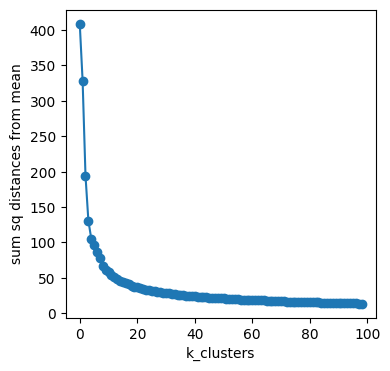

In [19]:
# Perform the cluster algorithm k_max times and calculate the sum squared distances from mean.
cluster_errors = []

k_max = 100
for i in range(1, k_max):
    if i%10 == 0: print(i)
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_init='auto',
                                                  n_clusters=n_clusters,
                                                  random_state=SEED,
                                                  verbose=0)
                                )])

    pipe_pca_kmean.fit(X_reduced)
    pipe_pca_kmean.predict(X_reduced)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

# Plot the sum squared distances from mean.
plt.clf()
plt.figure(figsize=(4,4))
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [20]:
# Find the optimal value of k with KneeLocator.
kl = KneeLocator(range(1, k_max), cluster_errors, curve="convex", direction="decreasing")

# Predict the clusters on our dataset

In [21]:
k_optimal = kl.elbow
print('k_optimal = ', k_optimal)

k_optimal =  10


In [22]:
from sklearn.cluster import KMeans

In [23]:
# Predict the clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
y_pred = kmeans.fit_predict(X_reduced)

# Plot the clustering: UMAP


In [24]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00


In [25]:
import time

import plotly.express as px
import seaborn as sns
from umap import UMAP

In [27]:
start_time = time.time()

# UMAP definition.
umap_embeddings = UMAP(min_dist=0.1, n_components=n_components)
X_umap = umap_embeddings.fit_transform(X_reduced)
print(f"\ncomputation time (s): {time.time()-start_time}")


# Plot.
x, y, z = list(zip(*X_umap))
fig = px.scatter_3d(df, x, y, z, color=y_pred.astype(str),
                    color_discrete_sequence=px.colors.qualitative.Dark24,
                    hover_data=['category', 'title'])
fig.update_traces(marker_size=3)
fig.show()


computation time (s): 29.969332218170166
